In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import dc_params_nsi, dc_params
from PINGU.event_processing import list_of_params_nsi, return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_deltachi as deltachi_DC
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)

C:\Users\Martin\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [105]:
ndim = 3
N=13
livetime = 2.45*365*24*3600 #Effective livetime table1 DC2019
precomputed_events = True
dc_params_nsi['dm_41'] = 0.93
dc_params['dm_41'] = 0.93
emm_range = np.linspace(-6e-2,6e-2,10)
s24_range = np.linspace(0,0,1)
emt_range = np.linspace(-3e-2,3e-2,10)
param_list = list_of_params_nsi(dc_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)



param_list = return_precomputed_nsi(1,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)

#print(param_list[1])

[-0.06       -0.04666667 -0.03333333 -0.02       -0.00666667  0.00666667  0.02        0.03333333  0.04666667  0.06      ]
[0.]
[-0.03       -0.02333333 -0.01666667 -0.01       -0.00333333  0.00333333  0.01        0.01666667  0.02333333  0.03      ]


In [107]:
H1_list = [pickle.load(open(f'./pre_computed/H1_PINGU_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_PINGU_{pid}.p','rb')) for pid in [0,1]]

H1_PINGU = np.array(H1_list)*livetime
H0_PINGU = np.array(H0_list)*livetime
H1_PINGU = np.swapaxes(H1_PINGU,0,1)

H1_list = [pickle.load(open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)}_tau_nsi.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_DC_{pid}.p','rb')) for pid in [0,1]]

H1_DC = np.array(H1_list)*livetime
H1_DC = np.swapaxes(H1_DC,0,1)

H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)*10}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))
H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
H1_IC = np.array(H1_list_normalized)

FileNotFoundError: [Errno 2] No such file or directory: './pre_computed/H1_N13_10x1x100_tau_nsi.p'

In [123]:
sigma_a = 0.25
sigma_b = 0.04
f_PINGU = 0#.05
f_DC = 2 # Not a percentage. Scales background pdf
f_IC = 0.1

PINGU_chisq,  best_fit_index_PINGU, min_chi2_PINGU = deltachi_PINGU([H for H in H1_PINGU],H0_PINGU,emt_range,emm_range,0,[sigma_a,sigma_b],f_PINGU,x0=[1,0])
DC_chisq,  best_fit_index_DC, min_chi2_DC =deltachi_DC([H for H in H1_DC],emt_range,emm_range,0,[sigma_a,sigma_b],f_DC,x0=[1,1,0])
#IC_chisq, best_indexIC, min_chi2_IC = deltachi_IC(H1_IC, None,np.linspace(-1e-2,1e-2,100),emm_range,0,[sigma_a,sigma_b],f_IC,x0=[1])
#IC_chisq = IC_chisq[::10]
PINGU_deltachi = PINGU_chisq - PINGU_chisq.min()
DC_deltachi = DC_chisq - DC_chisq.min()
#IC_deltachi = IC_chisq - IC_chisq.min()

In [124]:
global_chisq =  PINGU_chisq  + DC_chisq#+ IC_chisq
chibar = global_chisq - min_chi2_DC  - min_chi2_PINGU #- min_chi2_IC
1-chi2.cdf(chibar.min(),df=2)

0.9599461582993905

In [102]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
salvado_emt = (-6e-3*3, 5.4e-3*3)
dc_2017_emt = (-6.7e-3*3, 8.1e-3*3)
demidov_emt = (-0.023, 0.016)
demidov_emm = (-0.055, 0.056)
ax.plot(emt_range, PINGU_deltachi,label='PINGU', alpha=0.4)
ax.plot(emt_range, DC_deltachi,label='DC', alpha=0.4)
ax.plot(emt_range, IC_deltachi,label='IC', alpha=0.4)
ax.plot(emt_range, chibar - chibar.min(),label='joint')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')

ax.axvline(demidov_emt[0], alpha=0.6,c='black', label='Demidov (DC) 2020')
ax.axvline(demidov_emt[1], alpha=0.6,c='black')

ax.axvline(salvado_emt[0], alpha=0.6,c='black', label='Salvado (IC) 2017', ls=':')
ax.axvline(dc_2017_emt[0], alpha=0.6,c='black', label='DC 2017',ls='--')
ax.axvline(dc_2017_emt[1], alpha=0.6,c='black',ls='--')
ax.axvline(salvado_emt[1], alpha=0.6,c='black', ls=':')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
ax.set_ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=10)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

In [103]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
salvado_emt = (-6e-3*3, 5.4e-3*3)
dc_2017_emt = (-6.7e-3*3, 8.1e-3*3)
demidov_emt = (-0.023, 0.016)
demidov_emm = (-0.055, 0.056)
ax.plot(emm_range, PINGU_deltachi,label='PINGU', alpha=0.4)
ax.plot(emm_range, DC_deltachi,label='DC', alpha=0.4)
ax.plot(emm_range, chibar - chibar.min(),label='joint', color='red')
ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')

ax.axvline(demidov_emm[0], alpha=0.6,c='black', label='Demidov (DC) 2020')
ax.axvline(demidov_emm[1], alpha=0.6,c='black')


#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
ax.set_ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
ax.set_xlabel(r'$\varepsilon_{\mu\mu}$', fontsize=10)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

<ipython-input-132-6493e27b6a98>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(labels=np.round(emt_range,3))
<ipython-input-132-6493e27b6a98>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_yticklabels(labels=np.round(emm_range,3))


<a list of 1 text.Text objects>

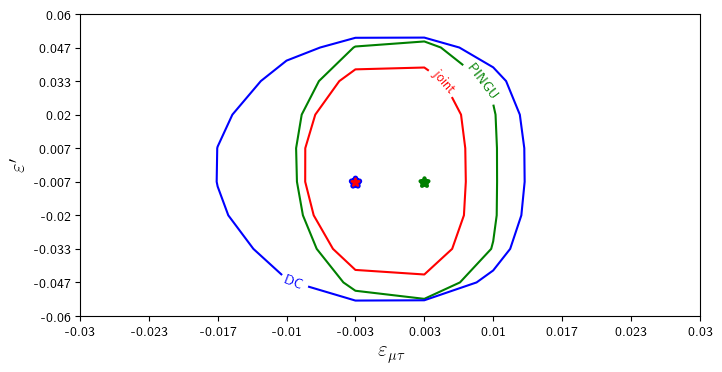

In [132]:
sandhya_emt = (-0.0043,0.0047)
sandhya_emm = (-0.03,0.017)

PINGU_deltachi_reshaped = PINGU_deltachi.reshape((len(emm_range), len(emt_range)))
DC_deltachi_reshaped = DC_deltachi.reshape((len(emm_range), len(emt_range)))
joint_deltachi_reshaped = (chibar - chibar.min()).reshape((len(emm_range), len(emt_range)))

best_fit_coords_PINGU = np.unravel_index(best_fit_index_PINGU,(len(emm_range),len(emt_range)))
best_fit_coords_DC = np.unravel_index(best_fit_index_DC,(len(emm_range),len(emt_range)))

best_fit_index_joint = np.argmin(joint_deltachi_reshaped)
best_fit_coords_joint = np.unravel_index(best_fit_index_joint,(len(emm_range),len(emt_range)))

fig, ax = plt.subplots(1,1, figsize=(8,4))
PINGU = ax.contour(PINGU_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)], colors='green')
DC = ax.contour(DC_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)],colors='blue')
joint = ax.contour(joint_deltachi_reshaped.T,levels = [chi2.ppf(q=0.9, df = 2)],colors='red')

ax.scatter(best_fit_coords_PINGU[0],best_fit_coords_PINGU[1], marker='*', color='green',lw=3)
ax.scatter(best_fit_coords_DC[0],best_fit_coords_DC[1], marker='*', color='blue', lw=4)
ax.scatter(best_fit_coords_joint[0],best_fit_coords_joint[1], marker='*', color='red', lw=1.5)
_=ax.set_xticklabels(labels=np.round(emt_range,3))
_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\varepsilon^\prime$', fontsize=15)


fmt_PINGU = {}
strs = ['PINGU']#,'f = 5 \%']
for l, s in zip(PINGU.levels, strs):
    fmt_PINGU[l] = s

fmt_DC = {}
strs = ['DC']
for l, s in zip(DC.levels, strs):
    fmt_DC[l] = s

fmt_joint = {}
strs = ['joint']
for l, s in zip(DC.levels, strs):
    fmt_joint[l] = s

ax.clabel(PINGU, PINGU.levels, inline=True, fmt=fmt_PINGU, fontsize=10)
ax.clabel(DC, DC.levels, inline=True, fmt=fmt_DC, fontsize=10)
ax.clabel(joint, joint.levels, inline=True, fmt=fmt_joint, fontsize=10)

In [80]:
sandhya_emt_right_index = np.argmin(np.abs(emt_range - sandhya_emt[1]))
sandhya_emt_left_index = np.argmin(np.abs(emt_range - sandhya_emt[0]))

sandhya_emm_right_index = np.argmin(np.abs(emm_range - sandhya_emm[1]))
sandhya_emm_left_index = np.argmin(np.abs(emm_range - sandhya_emm[0]))

In [83]:
emt_range

array([-0.03      , -0.02333333, -0.01666667, -0.01      , -0.00333333,  0.00333333,  0.01      ,  0.01666667,  0.02333333,  0.03      ])

In [84]:
emm_range

array([-0.06      , -0.04666667, -0.03333333, -0.02      , -0.00666667,  0.00666667,  0.02      ,  0.03333333,  0.04666667,  0.06      ])

In [128]:
SK_emm = (-0.147,0.147)
SK_emt = (-0.033,0.033)
SK_emt_right_index = np.argmin(np.abs(emt_range - SK_emt[1]))
SK_emt_left_index = np.argmin(np.abs(emt_range - SK_emt[0]))
SK_emm_right_index = np.argmin(np.abs(emm_range - SK_emm[1]))
SK_emm_left_index = np.argmin(np.abs(emm_range - SK_emm[0]))

In [133]:
sandhya_emt_right_index

5